Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2017/2018  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 5: Probabilistički grafički modeli, naivni Bayes, grupiranje i vrednovanje klasifikatora

*Verzija: 1.3  
Zadnji put ažurirano: 12. siječnja 2018.*

(c) 2015-2017 Jan Šnajder, Domagoj Alagić  

Objavljeno: **30. listopada 2018.**  
Rok za predaju: **22. siječnja 2018. u 07:00h**

------------------------------

### Upute

Prva laboratorijska vježba sastoji se od tri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import codecs
import mlutils
import matplotlib.pyplot as plt
import pgmpy as pgm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import codecs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

def load_SMS_dataset(path):
    X, y = [], []
    with codecs.open(path, "r", "utf-8") as fd:
        for line in fd:
            parts = line.split("\t")
            X.append(parts[1].strip())
            y.append(parts[0].strip())
    return np.array(X), np.array(y)

def plot_silhouette(n_clusters, X):
    # Kôd preuzet s http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Vrijednosti koeficijenta siluete")
    ax1.set_ylabel("Oznaka grupe")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")

    plt.show()

def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.02  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

def plot_2d_svc_problem(X, y, svc=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if SVC object is given, 
    the decision surfaces (with margin as well).
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if svc!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        Z = np.array([svc_predict(svc, x) for x in XX])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.Paired, marker='o', s=50)
    #plt.show()

def svc_predict(svc, x) : 
    h = svc.decision_function([x])
    if h >= -1 and h <= 1:
        return 0.5
    else: 
        return max(-1, min(1, h))

def plot_error_surface(err, c_range=(0,5), g_range=(0,5)):
    c1, c2 = c_range[0], c_range[1]
    g1, g2 = g_range[0], g_range[1]
    plt.xticks(range(0,g2-g1+1,5),range(g1,g2,5)); plt.xlabel("gamma")
    plt.yticks(range(0,c2-c1+1,5),range(c1,c2,5)); plt.ylabel("C")
    p = plt.contour(err);
    plt.imshow(1-err, interpolation='bilinear', origin='lower',cmap=plt.cm.gray)
    plt.clabel(p, inline=1, fontsize=10)
    #plt.show()


def knn_eval(n_instances=100, n_features=2, n_classes=2, n_informative=2, 
             test_size=0.3, k_range=(1, 20), n_trials=100):
    
    train_errors = []
    test_errors = []
    ks = list(range(k_range[0], k_range[1] + 1))

    for i in range(0, n_trials):
        X, y = make_classification(n_instances, n_features, n_classes=n_classes, 
                                   n_informative=n_informative, n_redundant=0, n_clusters_per_class=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        train = []
        test = []
        for k in ks:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            train.append(1 - knn.score(X_train, y_train))
            test.append(1 - knn.score(X_test, y_test))
        train_errors.append(train)
        test_errors.append(test)
        
    train_errors = np.mean(np.array(train_errors), axis=0)
    test_errors = np.mean(np.array(test_errors), axis=0)
    best_k = ks[np.argmin(test_errors)]
    
    return ks, best_k, train_errors, test_errors

### 1. Probabilistički grafički modeli -- Bayesove mreže

Ovaj zadatak bavit će se Bayesovim mrežama, jednim od poznatijih probabilističkih grafičkih modela (*probabilistic graphical models*; PGM). Za lakše eksperimentiranje koristit ćemo programski paket [`pgmpy`](https://github.com/pgmpy/pgmpy). Molimo Vas da provjerite imate li ovaj paket te da ga instalirate ako ga nemate.

#### (a)  
Prvo ćemo pogledati udžbenički primjer s prskalicom. U ovom primjeru razmatramo Bayesovu mrežu koja modelira zavisnosti između oblačnosti (slučajna varijabla $C$), kiše ($R$), prskalice ($S$) i mokre trave ($W$). U ovom primjeru također pretpostavljamo da već imamo parametre vjerojatnosnih distribucija svih čvorova. Ova mreža prikazana je na sljedećoj slici:

![This](http://www.fer.unizg.hr/_download/repository/bayes-net-sprinkler.jpg)

Koristeći paket `pgmpy`, konstruirajte Bayesovu mrežu iz gornjeg primjera. Zatim, koristeći **egzaktno** zaključivanje, postavite sljedeće posteriorne upite: $P(w=1)$, $P(s=1|w=1)$, $P(r=1|w=1)$, $P(c=1|s=1, r=1)$ i $P(c=1)$. Provedite zaključivanje na papiru i uvjerite se da ste ispravno konstruirali mrežu. Pomoći će vam službena dokumentacija te primjeri korištenja (npr. [ovaj](https://github.com/pgmpy/pgmpy/blob/dev/examples/Monte%20Hall%20Problem.ipynb)).

In [3]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination

In [4]:
# Defining the network structure
model = BayesianModel([('C', 'S'), ('C', 'R'), ('S', 'W'), ('R', 'W')])

# Defining the CPDs:
cpd_C = TabularCPD('C', 2, [[0.5, 0.5]])
cpd_S = TabularCPD('S', 2, [[0.5, 0.9], [0.5, 0.1]], evidence=['C'], evidence_card=[2])
cpd_R = TabularCPD('R', 2, [[0.8, 0.2],
                            [0.2, 0.8]], evidence=['C'], evidence_card=[2])
cpd_W = TabularCPD('W', 2, [[1, 0.1, 0.1, 0.01],
                            [0, 0.9, 0.9, 0.99]], evidence=['S', 'R'], evidence_card=[2,2])

# Associating the CPDs with the network structure.
model.add_cpds(cpd_C, cpd_S, cpd_R, cpd_W)

# Some other methods
model.get_cpds()

# check_model check for the model structure and the associated CPD and returns True if everything is correct otherwise throws an exception
model.check_model()

# Print all the tables
print(cpd_C)
print(cpd_S)
print(cpd_R)
print(cpd_W)

# Infering the posterior probability 
infer = VariableElimination(model)

print("1) P(W = 1)")
posterior_p1= infer.query(['W'])
print(posterior_p1['W'])

print("2) P(S = 1 | W = 1)")
posterior_p2 = infer.query(['S'], evidence = {'W':1})
print(posterior_p2['S'])

print("3) P(R = 1 | W = 1)")
posterior_p3 = infer.query(['R'], evidence = {'W':1})
print(posterior_p3['R'])

print("4) P(C = 1 | S = 1, R = 1)")
posterior_p5 = infer.query(['C'], evidence = {'S':1, 'R':1})
print(posterior_p5['C'])

print("5) P(C = 1)")
posterior_p6 = infer.query(['C'])
print(posterior_p6['C'])


╒═════╤═════╕
│ C_0 │ 0.5 │
├─────┼─────┤
│ C_1 │ 0.5 │
╘═════╧═════╛
╒═════╤═════╤═════╕
│ C   │ C_0 │ C_1 │
├─────┼─────┼─────┤
│ S_0 │ 0.5 │ 0.9 │
├─────┼─────┼─────┤
│ S_1 │ 0.5 │ 0.1 │
╘═════╧═════╧═════╛
╒═════╤═════╤═════╕
│ C   │ C_0 │ C_1 │
├─────┼─────┼─────┤
│ R_0 │ 0.8 │ 0.2 │
├─────┼─────┼─────┤
│ R_1 │ 0.2 │ 0.8 │
╘═════╧═════╧═════╛
╒═════╤═════╤═════╤═════╤══════╕
│ S   │ S_0 │ S_0 │ S_1 │ S_1  │
├─────┼─────┼─────┼─────┼──────┤
│ R   │ R_0 │ R_1 │ R_0 │ R_1  │
├─────┼─────┼─────┼─────┼──────┤
│ W_0 │ 1.0 │ 0.1 │ 0.1 │ 0.01 │
├─────┼─────┼─────┼─────┼──────┤
│ W_1 │ 0.0 │ 0.9 │ 0.9 │ 0.99 │
╘═════╧═════╧═════╧═════╧══════╛
1) P(W = 1)
╒═════╤══════════╕
│ W   │   phi(W) │
╞═════╪══════════╡
│ W_0 │   0.3529 │
├─────┼──────────┤
│ W_1 │   0.6471 │
╘═════╧══════════╛
2) P(S = 1 | W = 1)
╒═════╤══════════╕
│ S   │   phi(S) │
╞═════╪══════════╡
│ S_0 │   0.5702 │
├─────┼──────────┤
│ S_1 │   0.4298 │
╘═════╧══════════╛
3) P(R = 1 | W = 1)
╒═════╤══════════╕
│ R   │   phi(R)

**Q:** Koju zajedničku vjerojatnosnu razdiobu ova mreža modelira? Kako tu informaciju očitati iz mreže?  
**Q:** U zadatku koristimo egzaktno zaključivanje. Kako ono radi?  
**Q:** Koja je razlika između posteriornog upita i MAP-upita?  
**Q:** Zašto je vjerojatnost $P(c=1)$ drugačija od $P(c=1|s=1,r=1)$ ako znamo da čvorovi $S$ i $R$ nisu roditelji čvora $C$?

#### (b)  
**Efekt objašnjavanja** (engl. *explaining away*) zanimljiv je fenomen u kojem se događa da se dvije varijable "natječu" za objašnjavanje treće. Ovaj fenomen može se primijetiti na gornjoj mreži. U tom se slučaju varijable prskalice ($S$) i kiše ($R$) "natječu" za objašnjavanje mokre trave ($W$). Vaš zadatak je pokazati da se fenomen zaista događa.

In [67]:
# Infering the posterior probability 
infer = VariableElimination(model)

print("W | S:\n ", infer.query(['W'], evidence={'S':1})['W'])
print("W | R:\n ", infer.query(['W'], evidence={'R':1})['W'])

print("S | W, R:\n ", infer.query(['S'], evidence={'W':1, 'R':1})['S'])
print("R | W, S:\n ", infer.query(['R'], evidence={'W':1, 'S':1})['R'])

print("W | R, S:\n ", infer.query(['W'], evidence={'R':1, 'S':1})['W'])

W | S:
  ╒═════╤══════════╕
│ W   │   phi(W) │
╞═════╪══════════╡
│ W_0 │   0.0730 │
├─────┼──────────┤
│ W_1 │   0.9270 │
╘═════╧══════════╛
W | R:
  ╒═════╤══════════╕
│ W   │   phi(W) │
╞═════╪══════════╡
│ W_0 │   0.0838 │
├─────┼──────────┤
│ W_1 │   0.9162 │
╘═════╧══════════╛
S | W, R:
  ╒═════╤══════════╕
│ S   │   phi(S) │
╞═════╪══════════╡
│ S_0 │   0.8055 │
├─────┼──────────┤
│ S_1 │   0.1945 │
╘═════╧══════════╛
R | W, S:
  ╒═════╤══════════╕
│ R   │   phi(R) │
╞═════╪══════════╡
│ R_0 │   0.6796 │
├─────┼──────────┤
│ R_1 │   0.3204 │
╘═════╧══════════╛
W | R, S:
  ╒═════╤══════════╕
│ W   │   phi(W) │
╞═════╪══════════╡
│ W_0 │   0.0100 │
├─────┼──────────┤
│ W_1 │   0.9900 │
╘═════╧══════════╛


**Q:** Kako biste svojim riječima opisali ovaj fenomen, koristeći se ovim primjerom?

#### (c)  
Koristeći [`BayesianModel.is_active_trail`](http://pgmpy.org/models.html#pgmpy.models.BayesianModel.BayesianModel.is_active_trail) provjerite jesu li varijable oblačnosti ($C$) i mokre trave ($W$) uvjetno nezavisne. Što mora vrijediti kako bi te dvije varijable bile uvjetno nezavisne? Provjerite korištenjem iste funkcije.

In [69]:
print("Independant C, W ?", model.is_active_trail('C', 'W'))

Independant C, W ? True


**Q:** Kako možemo na temelju grafa saznati koje dvije varijable su, uz neka opažanja, uvjetno nezavisne?  
**Q:** Zašto bismo uopće htjeli znati koje su varijable u mreži uvjetno nezavisne?

### 2. Vrednovanje modela (klasifikatora)  

Kako bismo se uvjerili koliko naš naučeni model zapravo dobro radi, nužno je provesti evaluaciju modela. Ovaj korak od presudne je važnosti u svim primjenama strojnog učenja, pa je stoga bitno znati provesti evaluaciju na ispravan način.

Vrednovat ćemo modele na stvarnom skupu podataka [*SMS Spam Collection*](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) [1], koji se sastoji od 5,574 SMS-poruka klasificiranih u dvije klase: spam (oznaka: *spam*) i ne-spam (oznaka: *ham*). Ako već niste, preuzmite skup podataka s poveznice ili sa stranice kolegija i stavite ga u radni direktorij (otpakirajte arhivu i preimenujte datoteku u `spam.csv` po potrebi). Sljedeći komad kôda učitava skup podataka i dijeli ga na podskupove za učenje i testiranje.

[1] *Almeida, T.A., GÃmez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.*

In [87]:
from sklearn.model_selection import train_test_split
spam_X, spam_y = load_SMS_dataset('./spam.csv')

spam_X_train, spam_X_test, spam_y_train, spam_y_test = \
    train_test_split(spam_X, spam_y, train_size=0.7, test_size=0.3, random_state=69)

#### (a)  
Prije nego što krenemo u vrednovanje modela za klasifikaciju spama, upoznat ćete se s jednostavnijom apstrakcijom cjelokupnog procesa učenja modela u biblioteci `scikit-learn`. Ovo je korisno zato što se učenje modela često sastoji od mnoštva koraka prije sâmog pozivanja magične funkcije `fit`: ekstrakcije podataka, ekstrakcije značajki, standardizacije, skaliranja, nadopunjavanjem nedostajućih vrijednosti i slično. 

U "standardnom pristupu", ovo se svodi na pozamašan broj linija kôda u kojoj konstantno proslijeđujemo podatke iz jednog koraka u sljedeći, tvoreći pritom cjevovod izvođenja. Osim nepreglednosti, ovakav pristup je često i sklon pogreškama, s obzirom na to da je dosta jednostavno proslijediti pogrešan skup podataka i ne dobiti pogrešku pri izvođenju kôda. Stoga je u biblioteci `scikit-learn` uveden razred [`pipeline.Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Kroz ovaj razred, svi potrebni koraci učenja mogu se apstrahirati iza jednog cjevovoda, koji je opet zapravo model s `fit` i `predict` funkcijama.

U ovom zadatku ćete napraviti samo jednostavni cjevovod modela za klasifikaciju teksta, koji se sastoji od pretvorbe teksta u vektorsku reprezentaciju vreće riječi s TF-IDF-težinama, redukcije dimenzionalnosti pomoću krnje dekompozicije singularnih vrijednosti, normalizacije, te konačno logističke regresije.

**NB:** Nije sasvim nužno znati kako rade ovi razredi pomoću kojih dolazimo do konačnih značajki, ali preporučamo da ih proučite ako vas zanima (posebice ako vas zanima obrada prirodnog jezika).

In [186]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Prvo, prilažemo kôd koji to radi "standardnim pristupom":

In [187]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=500)
spam_X_feat_train = vectorizer.fit_transform(spam_X_train)
# Smanjenje dimenzionalnosti
reducer = TruncatedSVD(n_components=300, random_state=69)
spam_X_feat_train = reducer.fit_transform(spam_X_feat_train)
# Normaliziranje
normalizer = Normalizer()
spam_X_feat_train = normalizer.fit_transform(spam_X_feat_train)
# NB
clf = LogisticRegression()
clf.fit(spam_X_feat_train, spam_y_train)

# I sada ponovno sve ovo za testne podatke.
spam_X_feat_test = vectorizer.transform(spam_X_test)
spam_X_feat_test = reducer.transform(spam_X_feat_test)
spam_X_feat_test = normalizer.transform(spam_X_feat_test)

print(accuracy_score(spam_y_test, clf.predict(spam_X_feat_test)))

x_test = ["You were selected for a green card, apply here for only 50 USD!!!",
         "Hey, what are you doing later? Want to grab a cup of coffee?"]
x_test = vectorizer.transform(x_test)
x_test = reducer.transform(x_test)
x_test = normalizer.transform(x_test)
print(clf.predict(x_test))

0.965929468022
['spam' 'ham']


Vaš zadatak izvesti je dani kôd korištenjem cjevovoda. Proučite razred [`pipeline.Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

**NB** Ne treba vam više od svega nekoliko naredbi.

In [188]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer()), 
    ('red', TruncatedSVD()), 
    ('norm', Normalizer()), 
    ('clf', LogisticRegression())])

pipeline.set_params(
    vec__stop_words="english",
    vec__ngram_range=(1,2), 
    vec__max_features=500,
    red__n_components=300,
    red__random_state=69)

pipeline.fit(spam_X_train, spam_y_train)
print(accuracy_score(spam_y_test, pipeline.predict(spam_X_test)))
x_test = ["You were selected for a green card, apply here for only 50 USD!!!",
         "Hey, what are you doing later? Want to grab a cup of coffee?"]
print(x_test)
print(pipeline.predict(x_test))

0.965929468022
['You were selected for a green card, apply here for only 50 USD!!!', 'Hey, what are you doing later? Want to grab a cup of coffee?']
['spam' 'ham']


#### (b)  
U prošlom smo podzadatku ispisali točnost našeg modela. Ako želimo vidjeti koliko je naš model dobar po ostalim metrikama, možemo iskoristiti bilo koju funkciju iz paketa [`metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Poslužite se funkcijom [`metrics.classification_report`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report), koja ispisuje vrijednosti najčešćih metrika. (Obavezno koristite naredbu `print` kako ne biste izgubili format izlaza funkcije.) Ispišite ponovno točnost za usporedbu.

In [189]:
from sklearn.metrics import classification_report, accuracy_score

In [190]:
print(classification_report(spam_y_test, pipeline.predict(spam_X_test)))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      1439
       spam       0.97      0.78      0.86       234

avg / total       0.97      0.97      0.96      1673



Potreba za drugim metrikama osim točnosti može se vidjeti pri korištenju nekih osnovnih modela (engl. *baselines*). Možda najjednostavniji model takvog tipa je model koji svrstava sve primjere u većinsku klasu (engl. *most frequent class*; MFC) ili označuje testne primjere nasumično (engl. *random*). Proučite razred [`dummy.DummyClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) i pomoću njega stvorite spomenute osnovne klasifikatore. Opet ćete trebati iskoristiti cjevovod kako biste došli do vektorskog oblika ulaznih primjera, makar ovi osnovni klasifikatori koriste samo oznake pri predikciji.

In [191]:
from sklearn.dummy import DummyClassifier

pipeline_mf = Pipeline([
    ('vec', TfidfVectorizer()), 
    ('red', TruncatedSVD()), 
    ('norm', Normalizer()), 
    ('clf', DummyClassifier())])

pipeline_mf.set_params(
    vec__stop_words="english",
    vec__ngram_range=(1,2), 
    vec__max_features=500,
    red__n_components=300,
    red__random_state=69,
    clf__strategy="most_frequent")

pipeline_random = Pipeline([
    ('vec', TfidfVectorizer()), 
    ('red', TruncatedSVD()), 
    ('norm', Normalizer()), 
    ('clf', DummyClassifier())])

pipeline_random.set_params(
    vec__stop_words="english",
    vec__ngram_range=(1,2), 
    vec__max_features=500,
    red__n_components=300,
    red__random_state=69,
    clf__strategy="uniform")

pipeline_mf.fit(spam_X_train, spam_y_train)
pipeline_random.fit(spam_X_train, spam_y_train)

print(classification_report(spam_y_test, pipeline_mf.predict(spam_X_test)))
print(classification_report(spam_y_test, pipeline_random.predict(spam_X_test)))

             precision    recall  f1-score   support

        ham       0.86      1.00      0.92      1439
       spam       0.00      0.00      0.00       234

avg / total       0.74      0.86      0.80      1673

             precision    recall  f1-score   support

        ham       0.85      0.50      0.63      1439
       spam       0.13      0.44      0.20       234

avg / total       0.75      0.49      0.57      1673



C:\Users\lmark\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Q:** Na temelju ovog primjera objasnite zašto točnost nije uvijek prikladna metrika.  
**Q:** Zašto koristimo F1-mjeru?

#### (c)  
Međutim, provjera za kakvom smo posegli u prošlom podzadatku nije robusna. Stoga se u strojnom učenju obično koristi k-struka unakrsna provjera. Proučite razred [`model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) i funkciju [`model_selection.cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) te izračunajte procjenu pogreške na cijelom skupu podataka koristeći peterostruku unakrsnu provjeru. 

**NB:** Vaš model je sada cjevovod koji sadrži čitavo pretprocesiranje. Također, u nastavku ćemo se ograničiti na točnost, ali ovi postupci vrijede za sve metrike.

In [192]:
from sklearn.model_selection import cross_val_score, KFold

In [195]:
# Split data for k-fold cv
fold_count = 5
kf = KFold(n_splits=fold_count)#, shuffle=True, random_state=77)

pipeline = Pipeline([
        ('vec', TfidfVectorizer()), 
        ('red', TruncatedSVD()), 
        ('norm', Normalizer()), 
        ('clf', LogisticRegression())])

pipeline.set_params(
    vec__stop_words="english",
    vec__ngram_range=(1,2), 
    vec__max_features=500,
    red__n_components=300,
    red__random_state=69)

kcv_score = []
for train_index, test_index in kf.split(spam_X):
    
    _X_train, _y_train = spam_X[train_index], spam_y[train_index]
    _X_test, _y_test = spam_X[test_index], spam_y[test_index]
    
    # Train model
    pipeline.fit(_X_train, _y_train)
    kcv_score.append(accuracy_score(_y_test, pipeline.predict(_X_test)))
    
print("Cross validation score(own): ", kcv_score)
print("Cross validation score(builtin): ", cross_val_score(pipeline, spam_X, spam_y, cv=fold_count))

Cross validation score(own):  [0.97668161434977574, 0.97668161434977574, 0.96860986547085204, 0.97040358744394617, 0.97666068222621183]
Cross validation score(builtin):  [ 0.97670251  0.97670251  0.96588869  0.97127469  0.97576302]


**Q:** Zašto "obična" unakrsna provjera nije dovoljno robusna?  
**Q:** Što je to stratificirana k-struka unakrsna provjera? Zašto ju često koristimo?  

#### (d)  

Gornja procjena pogreške je u redu ako imamo već imamo model (bez ili s fiksiranim hiperparametrima). Međutim, mi želimo koristiti model koji ima optimalne vrijednosti hiperparametara te ih je stoga potrebno optimirati korištenjem pretraživanja po rešetci (engl. *grid search*). Očekivano, biblioteka `scikit-learn` već ima ovu funkcionalnost u razredu [`model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Jedina razlika vaše implementacije iz prošlih vježbi (npr. kod SVM-a) i ove jest ta da ova koristi k-struku unakrsnu provjeru.

Prije optimizacije vrijednosti hiperparametara, očigledno moramo definirati i samu rešetku vrijednosti hiperparametara. Proučite kako se definira ista kroz rječnik u [primjeru](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py). 

Proučite spomenuti razred te pomoću njega pronađite i ispišite najbolje vrijednosti hiperparametara cjevovoda iz podzadatka (a): `max_features` $\in \{500, 1000\}$ i `n_components` $\in \{ 100, 200, 300 \}$ korištenjem pretraživanja po rešetci na skupu za učenje ($k=3$, kako bi išlo malo brže).

In [144]:
from sklearn.model_selection import GridSearchCV

In [197]:
max_features = (500, 1000)
n_components = (100, 200, 300)

pipeline = Pipeline([
        ('vec', TfidfVectorizer()), 
        ('red', TruncatedSVD()), 
        ('norm', Normalizer()), 
        ('clf', LogisticRegression())])

pipeline.set_params(
    vec__stop_words="english",
    vec__ngram_range=(1,2), 
    red__random_state=69)
        
parameters = {
    'vec__max_features':max_features,
    'red__n_components':n_components
    }

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)
grid_search.fit(spam_X, spam_y)
print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   10.5s finished


Best params:  {'red__n_components': 300, 'vec__max_features': 1000}
Best score:  0.975959813419


**Q:** Koja se metrika optimira pri ovoj optimizaciji?  
**Q:** Kako biste odredili broj preklopa $k$?  

#### (e)  
Ako želimo procijeniti pogrešku, ali pritom i napraviti odabir modela, tada se okrećemo ugniježđenoj k-strukoj unakrsnoj provjeri (engl. *nested k-fold cross validation*). U ovom zadatku ćete ju sami implementirati.

Implementirajte funkciju `nested_kfold_cv(clf, param_grid, X, y, k1, k2)` koja provodi ugniježđenu k-struku unakrsnu provjeru. Argument `clf` predstavlja vaš klasifikator, `param_grid` rječnik vrijednosti hiperparametara (isto kao i u podzadatku (d)), `X` i `y` označeni skup podataka, a `k1` i `k2` broj preklopa u vanjskoj, odnosno unutarnjoj petlji. Poslužite se razredima [`model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) i  [`model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

Funkcija vraća listu pogrešaka kroz preklope vanjske petlje.

In [198]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import zero_one_loss

In [199]:
def nested_kfold_cv(clf, param_grid, X, y, k1, k2):
    
    # Initialize K-folds 
    kfold = KFold(n_splits=k1, shuffle=True, random_state=33)
    
    # Initialize error list
    error_list = []
    
    # Go through all the folds...
    for train_index, test_index in kf.split(spam_X):
    
        _X_train, _y_train = spam_X[train_index], spam_y[train_index]
        _X_test, _y_test = spam_X[test_index], spam_y[test_index]

        # Train model with grid search - inner loop
        gridsearch = GridSearchCV(clf, param_grid, cv=k2)
        gridsearch.fit(_X_train, _y_train)
        
        # Do prediction on the best classificator
        best_classificator = grid_search.best_estimator_
        best_classificator.fit(_X_train, _y_train)
        
        # Calculate error
        test_error = zero_one_loss(_y_test, best_classificator.predict(_X_test))
        train_error = zero_one_loss(_y_train, best_classificator.predict(_X_train))        
        
        error_list.append((train_error, test_error))
        
    return error_list

**Q:** Kako biste odabrali koji su hiperparametri generalno najbolji, a ne samo u svakoj pojedinačnoj unutarnjoj petlji?  
**Q:** Čemu u konačnici odgovara procjena generalizacijske pogreške?

#### (f)  
Scenarij koji nas najviše zanima jest usporedba dvaju klasifikatora, odnosno, je li jedan od njih zaista bolji od drugog. Jedini način kako to možemo zaista potvrditi jest statističkom testom, u našem slučaju **uparenim t-testom**. Njime ćemo se baviti u ovom zadatku.

Radi bržeg izvođenja, umjetno ćemo generirati podatke koji odgovaraju pogreškama kroz vanjske preklope dvaju klasifikatora (ono što bi vratila funkcija `nested_kfold_cv`):

In [200]:
np.random.seed(1337)
C1_scores_5folds = np.random.normal(78, 4, 5)
C2_scores_5folds = np.random.normal(81, 2, 5)

C1_scores_10folds = np.random.normal(78, 4, 10)
C2_scores_10folds = np.random.normal(81, 2, 10)

C1_scores_50folds = np.random.normal(78, 4, 50)
C2_scores_50folds = np.random.normal(81, 2, 50)

Iskoristite ugrađenu funkciju [`scipy.stats.ttest_rel`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html) za provedbu uparenog t-testa i provjerite koji od ova modela je bolji kada se koristi 5, 10 i 50 preklopa.

In [182]:
from scipy.stats import ttest_rel

In [201]:
print("5 folds - (t-value, p-value): ", ttest_rel(C2_scores_5folds, C1_scores_5folds))
print("10 folds - (t-value, p-value)", ttest_rel(C2_scores_10folds, C1_scores_10folds))
print("50 folds - (t-value, p-value)", ttest_rel(C2_scores_50folds, C1_scores_50folds))

5 folds - (t-value, p-value):  Ttest_relResult(statistic=1.9936398023627793, pvalue=0.11696313548164915)
10 folds - (t-value, p-value) Ttest_relResult(statistic=0.8842099536936594, pvalue=0.3995873733387435)
50 folds - (t-value, p-value) Ttest_relResult(statistic=5.8240553160508179, pvalue=4.3638376885602463e-07)


**Q:** Koju hipotezu $H_0$ i alternativnu hipotezu $H_1$ testiramo ovim testom?  
**Q:** Koja pretpostavka na vjerojatnosnu razdiobu primjera je napravljena u gornjem testu? Je li ona opravdana?  
**Q:** Koji je model u konačnici bolji i je li ta prednost značajna uz $\alpha = 0.05$?  

### 3. Grupiranje

U ovom zadatku ćete se upoznati s algoritmom k-sredina (engl. *k-nearest neighbours*), njegovim glavnim nedostatcima te pretpostavkama. Također ćete isprobati i drugi algoritam grupiranja: model Gaussovih mješavina (engl. *Gaussian mixture model*).

#### (a)  
Jedan od nedostataka algoritma k-sredina jest taj što unaprijed zahtjeva broj grupa ($K$) u koje će grupirati podatke. Ta informacija nam često nije dostupna (kao što nam nisu dostupne ni oznake primjera) te je stoga potrebno nekako izabrati najbolju vrijednost hiperparametra $K$. Jedan od naivnijih pristupa jest **metoda lakta/koljena** (engl. *elbow method*) koju ćete isprobati u ovom zadatku.

U svojim rješenjima koristite ugrađenu implementaciju algoritma k-sredina, dostupnoj u razredu [`cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

**NB**: Kriterijska funkcija algoritma k-sredina još se i naziva **inercijom** (engl. *inertia*). Za naučeni model, vrijednost kriterijske funkcije $J$ dostupna je kroz razredni atribut `inertia_`.

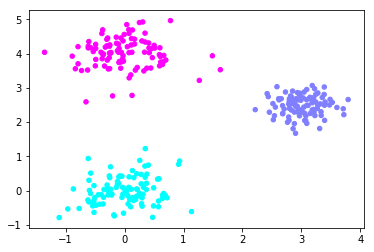

In [6]:
from sklearn.datasets import make_blobs

Xp, yp = make_blobs(n_samples=300, n_features=2, centers=[[0, 0], [3, 2.5], [0, 4]], 
                    cluster_std=[0.45, 0.3, 0.45], random_state=96)
plt.scatter(Xp[:,0], Xp[:,1], c=yp, cmap=plt.get_cmap("cool"), s=20)

Iskoristite skup podataka `Xp` dan gore. Isprobajte vrijednosti hiperparametra $K$ iz $[0,1,\ldots,15]$. Ne trebate dirati nikakve hiperparametre modela osim $K$. Iscrtajte krivulju od $J$ u ovisnosti o broju grupa $K$. Metodom lakta/koljena odredite vrijednost hiperparametra $K$.

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pylab as plt

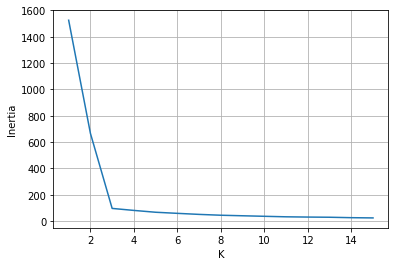

In [10]:
k_list = [num for num in range(1, 16)]

inertia_list = []
for k in k_list: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Xp)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(k_list, inertia_list)
plt.grid("on")
plt.xlabel("K")
plt.ylabel("Inertia");

**Q:** Koju biste vrijednost hiperparametra $K$ izabrali na temelju ovog grafa? Zašto? Je li taj odabir optimalan? Kako to znate?    
**Q:** Je li ova metoda robusna?  
**Q:** Možemo li izabrati onaj $K$ koji minimizira pogrešku $J$? Objasnite.

#### (b)  
Odabir vrijednosti hiperparametra $K$ može se obaviti na mnoštvo načina. Pored metode lakta/koljena, moguće je isto ostvariti i analizom siluete (engl. *silhouette analysis*). Za to smo pripremili funkciju `mlutils.plot_silhouette` koja za dani broj grupa i podatke iscrtava prosječnu vrijednost koeficijenta siluete i vrijednost koeficijenta svakog primjera (kroz grupe). 

Vaš je zadatak isprobati različite vrijednosti hiperparametra $K$, $K \in \{2, 3, 5\}$ i na temelju dobivenih grafova odlučiti se za optimalan $K$.

For n_clusters = 2 The average silhouette_score is : 0.592807961698


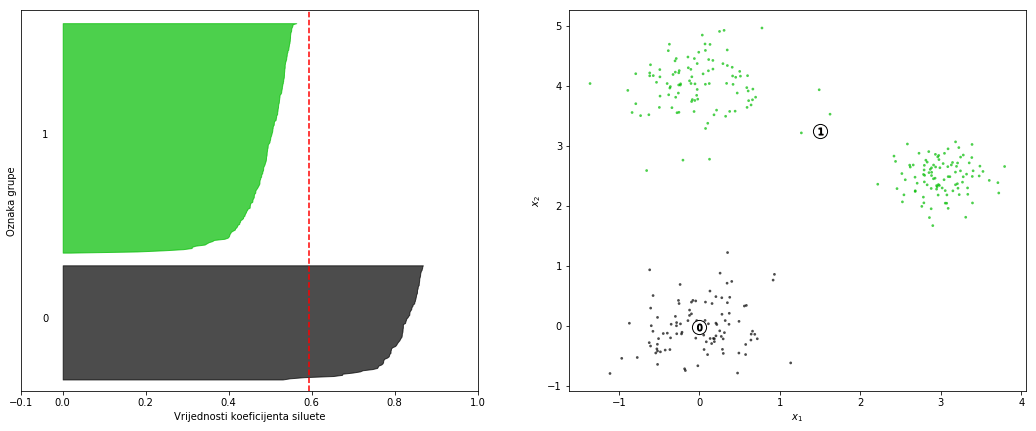

For n_clusters = 3 The average silhouette_score is : 0.797546221206


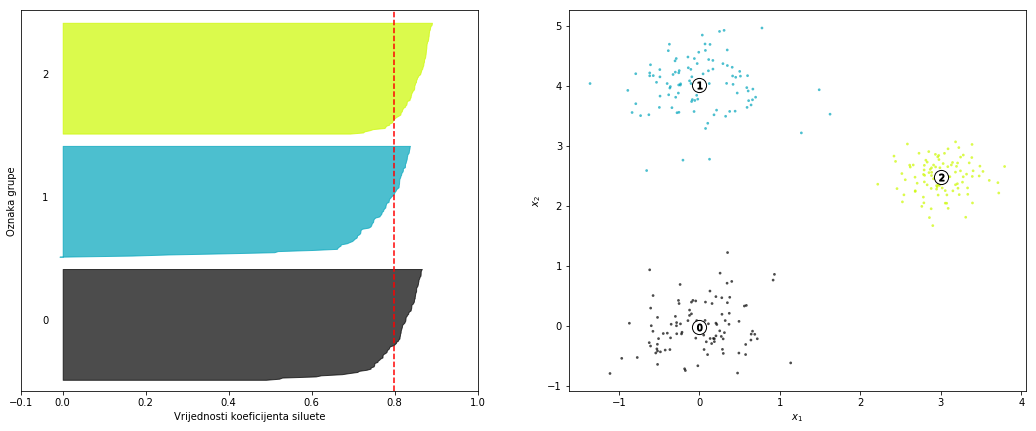

For n_clusters = 5 The average silhouette_score is : 0.505237176601


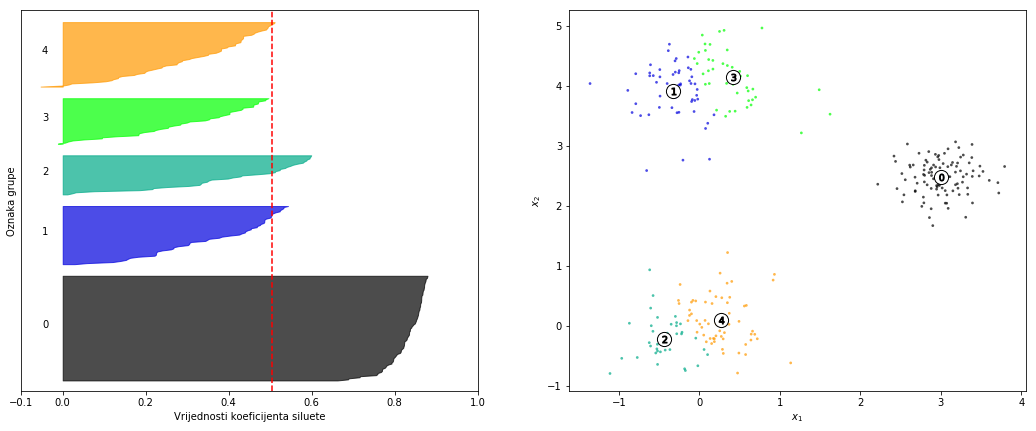

In [12]:
K_list = [2, 3, 5]

for k in K_list:
    plt.figure()
    plot_silhouette(k, Xp)

**Q:** Kako biste se gledajući ove slike odlučili za $K$?  
**Q:** Koji su problemi ovog pristupa?

#### (c)  
U ovom i sljedećim podzadatcima fokusirat ćemo se na temeljne pretpostavke algoritma k-srednjih vrijednosti te što se događa ako te pretpostavke nisu zadovoljene. Dodatno, isprobat ćemo i grupiranje modelom Gaussovih mješavina (engl. *Gaussian Mixture Models*; GMM) koji ne nema neke od tih pretpostavki.

Prvo, krenite od podataka `X1`, koji su generirani korištenjem funkcije [`datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html), koja stvara grupe podataka pomoću izotropskih Gaussovih distribucija.

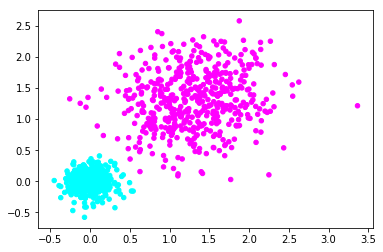

In [13]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0], [1.3, 1.3]], cluster_std=[0.15, 0.5], random_state=96)
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.get_cmap("cool"), s=20)

Naučite model k-srednjih vrijednosti (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

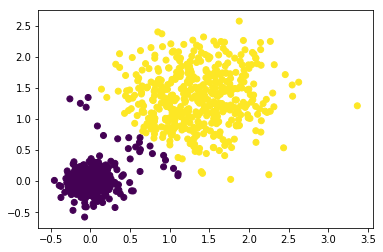

In [14]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X1, y1)
y_hat = kmeans.predict(X1)
plt.scatter(X1[:,0], X1[:,1], c=y_hat)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-srednjih vrijednosti ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (d)

Isprobajte algoritam k-srednjih vrijednosti na podatcima generiranim korištenjem funkcije [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), koja stvara dvije grupe podataka tako da je jedna unutar druge.

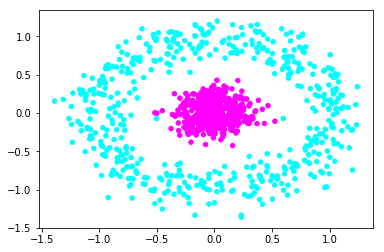

In [20]:
from sklearn.datasets import make_circles

X2, y2 = make_circles(n_samples=1000, noise=0.15, factor=0.05, random_state=96)
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.get_cmap("cool"), s=20)

Ponovno, naučite model k-srednjih vrijednosti (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

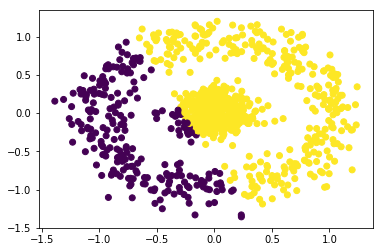

In [21]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X2, y2)
y_hat = kmeans.predict(X2)
plt.scatter(X2[:,0], X2[:,1], c=y_hat)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-srednjih vrijednosti ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (e)  
Završno, isprobat ćemo algoritam na sljedećem umjetno stvorenom skupu podataka:

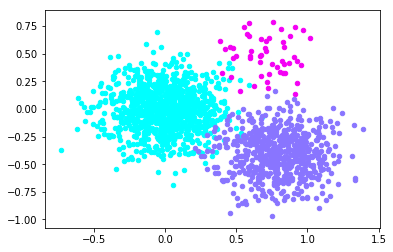

In [17]:
X31, y31 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0]], cluster_std=[0.2], random_state=69)
X32, y32 = make_blobs(n_samples=50, n_features=2, centers=[[0.7, 0.5]], cluster_std=[0.15], random_state=69)
X33, y33 = make_blobs(n_samples=600, n_features=2, centers=[[0.8, -0.4]], cluster_std=[0.2], random_state=69)
plt.scatter(X31[:,0], X31[:,1], c="#00FFFF", s=20)
plt.scatter(X32[:,0], X32[:,1], c="#F400F4", s=20)
plt.scatter(X33[:,0], X33[:,1], c="#8975FF", s=20)

# Just join all the groups in a single X.
X3 = np.vstack([X31, X32, X33])
y3 = np.hstack([y31, y32, y33])

Ponovno, naučite model k-srednjih vrijednosti (ovaj put idealno pretpostavljajući $K=3$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

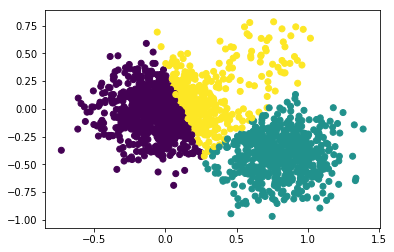

In [18]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X3, y3)
y_hat = kmeans.predict(X3)
plt.scatter(X3[:,0], X3[:,1], c=y_hat)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-srednjih vrijednosti ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (f)  
Sada kada ste se upoznali s ograničenjima algoritma k-srednjih vrijednosti, isprobat ćete grupiranje modelom mješavine Gaussa (*Gaussian Mixture Models; GMM*), koji je generalizacija algoritma k-srednjih vrijednosti (odnosno, algoritam k-srednjih vrijednosti specijalizacija je GMM-a). Implementacija ovog modela dostupna je u [`mixture.GaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture). Isprobajte ovaj model (s istim pretpostavkama o broju grupa) na podacima iz podzadataka (a)-(c). Ne morate mijenjati nikakve hiperparametre ni postavke osim broja komponenti.

In [19]:
from sklearn.mixture import GaussianMixture

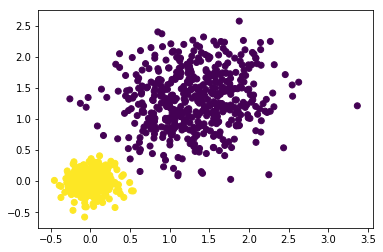

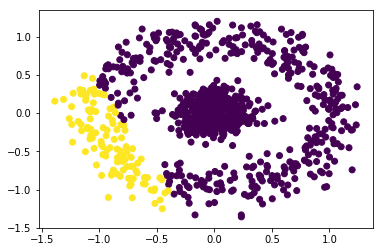

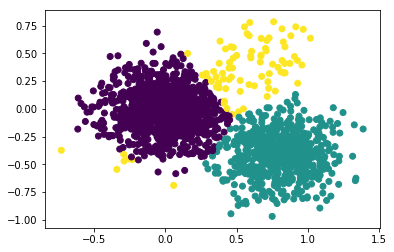

In [239]:
plt.figure()
gmm = GaussianMixture(n_components=2)
gmm.fit(X1, y1)
y_hat = gmm.predict(X1)
plt.scatter(X1[:,0], X1[:,1], c=y_hat)

plt.figure()
gmm = GaussianMixture(n_components=2)
gmm.fit(X2, y2)
y_hat = gmm.predict(X2)
plt.scatter(X2[:,0], X2[:,1], c=y_hat)

plt.figure()
gmm = GaussianMixture(n_components=3)
gmm.fit(X3, y3)
y_hat = gmm.predict(X3)
plt.scatter(X3[:,0], X3[:,1], c=y_hat)

#### (g)  
Kako vrednovati točnost modela grupiranja ako imamo stvarne oznake svih primjera (a u našem slučaju imamo, jer smo mi ti koji smo generirali podatke)? Često korištena mjera jest **Randov indeks** koji je zapravo pandan točnosti u zadatcima klasifikacije. Implementirajte funkciju `rand_index_score(y_gold, y_predict)` koja ga računa. Funkcija prima dva argumenta: listu stvarnih grupa kojima primjeri pripadaju (`y_gold`) i listu predviđenih grupa (`y_predict`). Dobro će vam doći funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

In [252]:
import itertools as it

def rand_index_score(y_gold, y_predict):
    
    # Pairs that are equally marked and are in the same group
    a = 0
    
    # Pairs that are differently marked and are in different groups
    b = 0
    
    for actual_comb, predict_comb in zip(
        it.combinations(y_gold, 2), it.combinations(y_predict, 2)):
        
        if (predict_comb[0] == predict_comb[1] and # Equally marked
           actual_comb[0] == actual_comb[1]):# ... and in the same group
            a = a+1
            
        if (predict_comb[0] != predict_comb[1] and # Differently marked
           actual_comb[0] != actual_comb[1]):# ... and not in the same group
            b = b+1

    k = len(set(y_gold))
    print(k)
    N = len(y_gold)
    print(N)
    return ((a+b) * math.factorial(k) * math.factorial(N-k) / math.factorial(N))

**Q:** Zašto je Randov indeks pandan točnosti u klasifikacijskim problemima?  
**Q:** Koji su glavni problemi ove metrike?  
**Q:** Zašto se koristi modificirani Randov indeks (engl. *adjusted Rand index*)?  
**Q:** Kako vrednovati kvalitetu grupiranja ako nenamo stvarne oznake primjera? Je li to uopće moguće?

In [253]:
print(rand_index_score(
    [1,1,1,1,1,2,2,2,2,2,2,2,2], 
    [1,1,1,1,2,1,1,2,2,2,2,2,2]))

2
13
0.6153846153846154
